In [125]:
from vega import Vega
import json
import altair as alt

import pandas as pd
artefacts_data = pd.read_csv("artefacts-overview-stats.csv")

# Overview

*BETA* - DO NOT TRUST THE NUMBERS IN THIS NOTEBOOK!

In [121]:
tree_totals = artefacts_data.groupby('type').sum(numeric_only=True)
tree_structure = [ { "id": 1, "name": "National Collection" } ]
tree_node_index = 2
#tree_totals.columns
parent_map = {}
for row in tree_totals.iterrows():
  parent_map[row[0]] = tree_node_index
  tree_structure.append({"id": tree_node_index, "name": row[0], 
                         "parent": 1})
  tree_node_index+= 1

In [122]:
from collections import Counter
institution_type_index = Counter()
for i, row in artefacts_data.iterrows():
    tree_structure.append({"id": tree_node_index, "name": row["institution"], 
                           "size": int(row["artefact_count"]), 
                         "parent": parent_map[row['type']]})
    institution_type_index[row["type"]] += 1
    tree_node_index+=1

In [123]:
treemap_test_spec = f"""
{{
  "$schema": "https://vega.github.io/schema/vega/v5.json",
  "description": "An example of treemap layout for hierarchical data.",
  "width": 960,
  "height": 500,
  "padding": 2.5,
  "autosize": "none",
  "signals": [
  ],
  "data": [
    {{
      "name": "tree",
      "values": {json.dumps(tree_structure)},
      "transform": [
        {{"type": "stratify", "key": "id", "parentKey": "parent"}},
        {{
          "type": "treemap",
          "field": "size",
          "sort": {{"field": "value"}},
          "round": true,
          "method": "squarify",
          "ratio": 1.6,
          "size": [{{"signal": "width"}}, {{"signal": "height"}}]
        }}
      ]
    }},
    {{
      "name": "nodes",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "datum.children"}}]
    }},
    {{
      "name": "leaves",
      "source": "tree",
      "transform": [{{"type": "filter", "expr": "!datum.children"}}]
    }}
  ],
  "scales": [
    {{
      "name": "color",
      "type": "ordinal",
      "domain": {{"data": "nodes", "field": "name"}},
      "range": [
        "#3182bd",
        "#6baed6",
        "#9ecae1",
        "#c6dbef",
        "#e6550d",
        "#fd8d3c",
        "#fdae6b",
        "#fdd0a2",
        "#31a354",
        "#74c476",
        "#a1d99b",
        "#c7e9c0",
        "#756bb1",
        "#9e9ac8",
        "#bcbddc",
        "#dadaeb",
        "#636363",
        "#969696",
        "#bdbdbd",
        "#d9d9d9"
      ]
    }},
    {{
      "name": "size",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [256, 28, 20, 14]
    }},
    {{
      "name": "opacity",
      "type": "ordinal",
      "domain": [0, 1, 2, 3],
      "range": [0.15, 0.5, 0.8, 1]
    }}
  ],
  "marks": [
    {{
      "type": "rect",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{"fill": {{"scale": "color", "field": "name"}} }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}}
        }}
      }}
    }},
    {{
      "type": "rect",
      "from": {{"data": "leaves"}},
      "encode": {{
        "enter": {{"stroke": {{"value": "#fff"}},
                  "tooltip": {{ "field": "name" }}
        }},
        "update": {{
          "x": {{"field": "x0"}},
          "y": {{"field": "y0"}},
          "x2": {{"field": "x1"}},
          "y2": {{"field": "y1"}},
          "fill": {{"value": "transparent"}}
        }},
        "hover": {{"fill": {{"value": "#efb118"}} }}
      }}
    }},
    {{
      "type": "text",
      "from": {{"data": "nodes"}},
      "interactive": false,
      "encode": {{
        "enter": {{
          "font": {{"value": "Helvetica Neue, Arial"}},
          "align": {{"value": "center"}},
          "baseline": {{"value": "middle"}},
          "fill": {{"value": "#000"}},
          "text": {{"field": "name"}},
          "fontSize": {{"scale": "size", "field": "depth"}},
          "fillOpacity": {{"scale": "opacity", "field": "depth"}}
        }},
        "update": {{
          "x": {{"signal": "0.5 * (datum.x0 + datum.x1)"}},
          "y": {{"signal": "0.5 * (datum.y0 + datum.y1)"}}
        }}
      }}
    }}
  ]
}}
"""

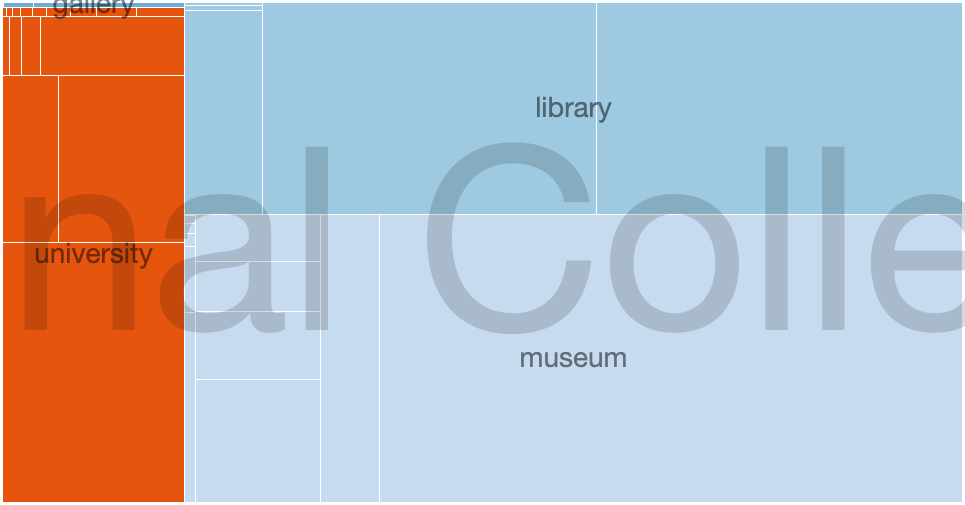

In [124]:
from IPython.display import display
import json
display({"application/vnd.vega.v5+json": json.loads(treemap_test_spec)}, raw=True)


An overview of how the UK National Collection is formed, broken down by type of holding public institution:
  * Museum
  * Gallery
  * Library
  * Universities (which can include a Museum, Gallery, Libraries and Archives)

And not yet featuring Archives as handling the hierarchical nature of archive cataloguing brings up more complexity that has not yet been resolved.

This type classification, like much in this area, is somewhat ill-defined; most museums and galleries also have an archive and many also have library items. To give an alternative lower level view, other notebooks will try to break collections down by sub-type, so all the library collections (either at a library institution or a library collection at a museum/gallery/university) are counted together. As with many datasets, there are many different views that can be taken of the data and each brings different insights (and biases), there is no one view that can reveal all facts in a single glance.